In [1]:
from bs4 import BeautifulSoup
from datetime import datetime as dt
import requests
from requests import get
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from datetime import datetime, date
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
df = pd.read_csv('Movies_gross_og.csv', index_col=0)

In [2]:
df['Genre'] = df['Genre'].apply(lambda x: x.split()).apply(lambda y: ','.join(y))

In [3]:
df['Rel_Date_ts'] = pd.to_datetime(df['Rel_Date_ts'])
df['Year'] = df['Rel_Date_ts'].dt.year

In [4]:
def str_to_min(time_str):

    #Spliting up string and get min and hour
    total_min=0
    time_str = time_str.split(' ')
    
    
    if len(time_str)>3:
        hour = time_str[0]
        minute = time_str[2]
        hour = int(hour)
        minute = int(minute)
        total_min = 60 * hour + minute
    else:
        total_min = int(time_str[0])
    

    #Convert to total minutes
    
    return total_min
df.loc[:, 'Run_time']=df['Runtime'].apply(str_to_min)

In [5]:
# Feature Engineering
df['Profit_log'] = np.log(df['World_Gr'] - df['Budget'])
df['Profit'] = (df['World_Gr'] - df['Budget'])/1000000
df['Domestic_Gr/Domestic_Open'] = df['Domestic_Gr'] / df['Domestic_Open']
df['Budget_sq'] = df['Budget']**2
df['PG-13_sq'] = df['PG-13']**2
df['Year_sq'] = df['Year']**2
df['Run_time_sq'] = df['Run_time']**2

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df.drop(['Title', 'Runtime','Genre','Approved','Rel_Date_ts'], axis=1, inplace=True)

In [7]:
df.isnull().values.any()

True

In [8]:
# Drop inf values from Profit_log
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [9]:
df.fillna(value=0, inplace=True)

In [10]:
df.isnull().values.any()

False

In [11]:
df.drop(df['Profit'].idxmax(), inplace=True)

In [12]:
df['Budget'] = df['Budget'].replace(0,df['Budget'].median())
df['Domestic_Gr'] = df['Domestic_Gr'].replace(0,df['Domestic_Gr'].median())
df['Inter_Gr'] = df['Inter_Gr'].replace(0,df['Inter_Gr'].median())
df['World_Gr'] = df['World_Gr'].replace(0,df['World_Gr'].median())
df['Domestic_Open'] = df['Domestic_Open'].replace(0,df['Domestic_Open'].median())
df['Budget_sq'] = df['Budget_sq'].replace(0,df['Budget_sq'].median())
df['Year_sq'] = df['Year_sq'].replace(0,df['Year_sq'].median())
df['Run_time_sq'] = df['Run_time_sq'].replace(0,df['Run_time_sq'].median())

In [13]:
A = df[['Budget','PG-13','Year','Run_time']]
b = df['Profit']

In [14]:
import statsmodels.api as sm
#Create the model
model = sm.OLS(b, sm.add_constant(A)) 

#Fit
fit = model.fit()

#Print out summary
fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     70.34
Date:                Fri, 01 Oct 2021   Prob (F-statistic):           1.75e-52
Time:                        07:53:22   Log-Likelihood:                -6866.1
No. Observations:                 999   AIC:                         1.374e+04
Df Residuals:                     994   BIC:                         1.377e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7543.0244   1328.535     -5.678      0.000   -1.02e+04   -4935.969
Budget      1.467e-06   1.47e-07     10.005      0.000    1.18e-06    1.76e-06
PG-13          5.7401     16.236      0.354      0.724     -26.120      37.600
Year           3.7545      0.663      5.659      0.000       2.453       5.057
Run_time       1.6713      0.294      5.676      0.000       1.094       2.249
==============================================================================
Omnibus:                      483.533   Durbin-Watson:                   0.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3572.878
Skew:                           2.092   Prob(JB):                         0.00
Kurtosis:                      11.266   Cond. No.                     1.80e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

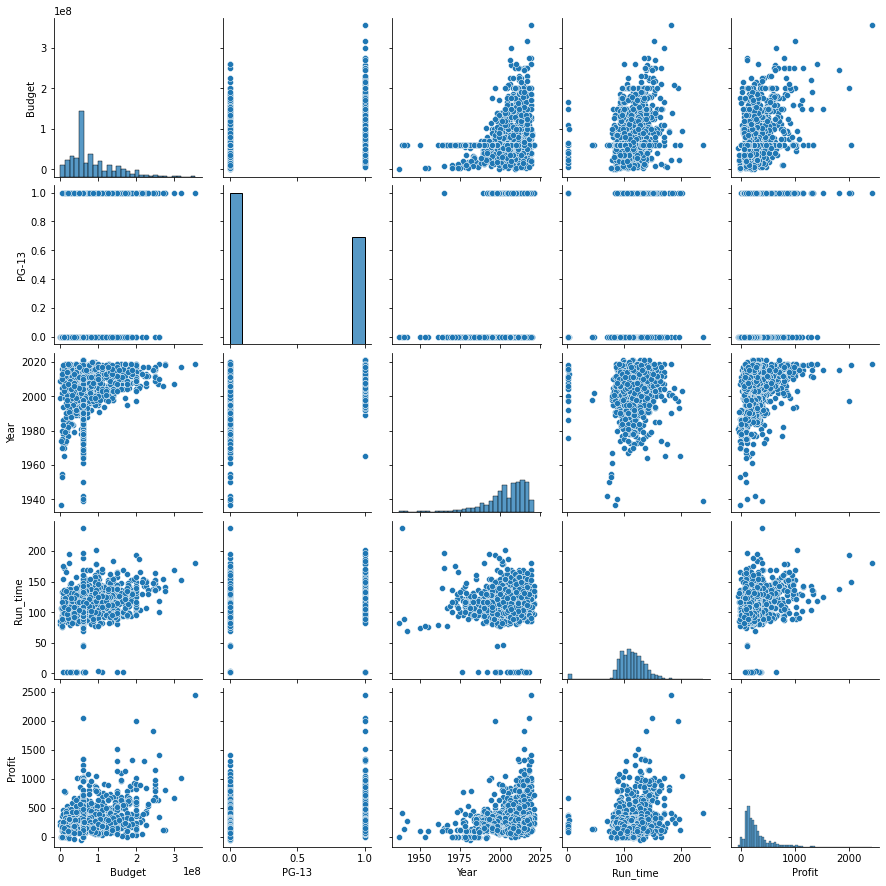

In [15]:
sns.pairplot(df[['Budget','PG-13','Year','Run_time', 'Profit']])

In [16]:
X, y = df.drop('Profit', axis=1), df['Profit']

In [17]:
X, y = df[['Budget','PG-13','Year','Run_time']], df['Profit']
X, X_test, y, y_test = train_test_split(X, y, test_size =.2, random_state=10)

In [18]:
# Training Score **Low and underfitting**
# lm = LinearRegression
# y_pred = lm.predict(X)
# print(r2_score(y, y_pred))

In [19]:
# # Test Score
# y_pred = lm.predict(X_test)
# print(r2_score(y_test, y_pred))

In [20]:
# Train, Test, Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [21]:
# Cross validation on Simple Linear Model
kf = KFold(n_splits=5, shuffle=True, random_state = 20)
lm = LinearRegression()
lm.fit(X, y)
print(cross_val_score(lm, X, y, cv=kf, scoring='r2'))
#average of 5
print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))

[0.23278742 0.1783926  0.03927665 0.24144379 0.14616844]
0.16761377956872775


In [22]:
#Scaling for Ridge and Lasso
std = StandardScaler()
std.fit(X.values)

X_scaled = std.transform(X.values)
X_test_scaled = std.transform(X_test.values)

In [23]:
#2nd Degree Polynomial
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)

In [24]:
#Polynomial Regression
kf = KFold(n_splits=5, shuffle=True, random_state = 20)
poly = LinearRegression()
poly.fit(X, y)
print(cross_val_score(lm, X_train_poly, y, cv=kf, scoring='r2'))
#average of 5
print(np.mean(cross_val_score(lm, X_train_poly, y, cv=kf, scoring='r2')))

[0.22566325 0.10709025 0.06937559 0.25905796 0.26100694]
0.18443879975557959


In [25]:
#Finding the optimal alpha for Ridge model
rm = RidgeCV(alphas=[0.1, 1.0, 10.0])

new_ridge=rm.fit(X_scaled, y)
best_alpha = new_ridge.alpha_

print(best_alpha)

10.0


In [69]:
#Cross validation on Ridge Model
kf = KFold(n_splits=5, shuffle=True, random_state = 20)
RidgeCV = Ridge(alpha=10)

#Fit model
RidgeCV.fit(X_scaled, y)

#Results from ridge reg cross val
#All five values
print('All 5 scores:', cross_val_score(RidgeCV, X_scaled, y, cv=kf, scoring='r2'))
#Average of 5
print('Mean_score:', np.mean(cross_val_score(RidgeCV, X_scaled, y, cv=kf, scoring='r2')))

All 5 scores: [0.23234493 0.18143196 0.03952549 0.24129313 0.14752539]
Mean_score: 0.16842417866505727


In [27]:
#Finding the optimal alpha for lasso model
lasso = LassoCV(alphas=[0.1, 1.0, 10.0])

new_lasso=lasso.fit(X_scaled, y)
best_alpha = new_lasso.alpha_

print(best_alpha)

10.0


In [28]:
#Lasso CV Regresion 
kf = KFold(n_splits=5, shuffle=True, random_state = 20)
LassoCV = Lasso(alpha=10)

#Fit model
LassoCV.fit(X_scaled, y)

#Results from ridge reg cross val
#All five values
print('All 5 scores:', cross_val_score(LassoCV, X_scaled, y, cv=kf, scoring='r2'))
#Average of 5
print('Mean_score:', np.mean(cross_val_score(LassoCV, X_scaled, y, cv=kf, scoring='r2')))
print('Lasso_coefficients:', LassoCV.coef_)

All 5 scores: [0.23139132 0.20541528 0.0607617  0.23505336 0.13950568]
Mean_score: 0.1744254673215233
Lasso_coefficients: [71.05906335  0.         36.78525297 31.70121044]


In [29]:
test_set_pred_lasso = LassoCV.predict(X_test_scaled)

In [30]:
r2_score(y_test, test_set_pred_lasso)

0.20090398491247097

In [31]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

y_err=mae(y_test, test_set_pred_lasso)
print(y_err)

168.62639323518547


In [32]:
test_set_pred_lm = lm.predict(X_test)

In [33]:
r2_score(y_test, test_set_pred_lm)

0.21218141287786885

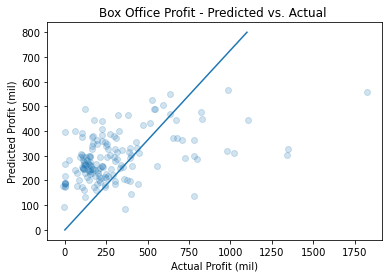

In [70]:
from matplotlib import pyplot as plt
plt.scatter(y_test, test_set_pred_lasso, alpha=.2)
plt.xlabel('Actual Profit (mil)')
plt.ylabel('Predicted Profit (mil)')
plt.title('Box Office Profit - Predicted vs. Actual ')
plt.plot([0,1100], [0, 800])

In [49]:
# SAME MODELS USED WITH SQUARED FEATURES 
X_sq, y_sq = df[['Budget_sq','PG-13_sq','Year_sq','Run_time_sq']], df['Profit']
X_sq, X_sq_test, y_sq, y_sq_test = train_test_split(X_sq, y_sq, test_size =.2, random_state=10)

In [59]:
# Cross validation on Simple Linear Model
kf = KFold(n_splits=5, shuffle=True, random_state = 20)
lm_sq = LinearRegression()
lm_sq.fit(X_sq, y_sq)
print(cross_val_score(lm_sq, X_sq, y_sq, cv=kf, scoring='r2'))
#average of 5
print(np.mean(cross_val_score(lm_sq, X_sq, y_sq, cv=kf, scoring='r2')))

#all five values
print('All 5 scores:', cross_val_score(lm_sq, X_sq, y_sq, cv=kf, scoring='r2'))
#average of 5
print('Mean_score:', np.mean(cross_val_score(lm_sq, X_sq, y_sq, cv=kf, scoring='r2')))
# print('Lr_coefficients:', lm_sq.coef_)

[0.20157738 0.1313448  0.17440202 0.24534436 0.30548231]
0.21163017338203155
All 5 scores: [0.20157738 0.1313448  0.17440202 0.24534436 0.30548231]
Mean_score: 0.21163017338203155


In [60]:
#Scaling for Ridge and Lasso   **Lines 5 and 6 different from above
std = StandardScaler()
std.fit(X.values)

X_sq_scaled = std.fit_transform(X_sq.values)
X_sq_test_scaled = std.fit_transform(X_sq_test.values)

In [61]:
#Cross validation on Ridge Model
kf = KFold(n_splits=5, shuffle=True, random_state = 20)
RidgeCV_sq = Ridge(alpha=10)

#fit model
RidgeCV_sq.fit(X_sq_scaled, y_sq)

#results from ridge reg cross val
#all five values
print(cross_val_score(RidgeCV_sq, X_sq_scaled, y_sq, cv=kf, scoring='r2'))
#average of 5
print(np.mean(cross_val_score(RidgeCV_sq, X_sq_scaled, y_sq, cv=kf, scoring='r2')))

[0.20041014 0.1277363  0.16451163 0.24554177 0.30409535]
0.2084590381559333


In [62]:
#Lasso CV Regression 
kf = KFold(n_splits=5, shuffle=True, random_state = 20)
LassoCV_sq = Lasso(alpha=10)

#fit model
LassoCV_sq.fit(X_scaled, y)

#results from ridge reg cross val
#all five values
print('All 5 scores:', cross_val_score(LassoCV_sq, X_sq_scaled, y_sq, cv=kf, scoring='r2'))
#average of 5
print('Mean_score:', np.mean(cross_val_score(LassoCV_sq, X_sq_scaled, y_sq, cv=kf, scoring='r2')))
print('Lasso_coefficients:', LassoCV.coef_)

All 5 scores: [0.19817031 0.13656969 0.1661391  0.24314035 0.29461594]
Mean_score: 0.20772707759721282
Lasso_coefficients: [71.05906335  0.         36.78525297 31.70121044]


In [63]:
# Squared features better predictors, pass test set through chosen Simple Linear Regression
test_set_pred_lm_sq = lm.predict(X_sq_test)

In [64]:
# Linear Regression model scored on test data
r2_score(y_sq_test, test_set_pred_lm_sq)

0.34879883983615967

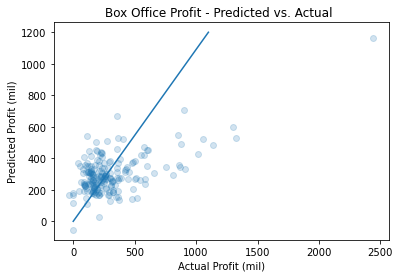

In [65]:
from matplotlib import pyplot as plt
plt.scatter(y_sq_test, test_set_pred_lm_sq, alpha=.2)
plt.xlabel('Actual Profit (mil)')
plt.ylabel('Predicted Profit (mil)')
plt.title('Box Office Profit - Predicted vs. Actual ')
plt.plot([0,1100], [0, 1200])

In [68]:
#Mean Absolute Error (Linear Regression)
def mae(y_true, y_pred):
    return np.mean(np.abs(test_set_pred_lm_sq - y_sq_test)) 

y_err=mae(y_sq_test, test_set_pred_lm_sq)
print(y_err)

156.55474730859154


Text(0.5, 1.0, 'Residuals vs. Predictions')

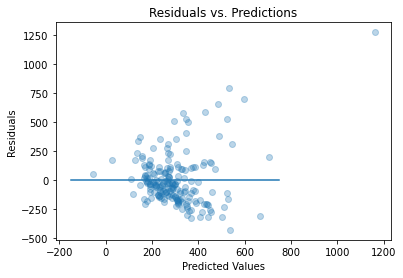

In [67]:
#Residuals scatter plot
lin_reg_residuals = y_sq_test - test_set_pred_lm_sq

plt.scatter(test_set_pred_lm_sq, lin_reg_residuals, alpha = 0.3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Box Office Profit - Predicted vs. Actual ')
plt.plot([-150,750], [0, 0])
plt.title("Residuals vs. Predictions")